In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import pyarrow.parquet as pq

from keras.optimizers import SGD

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import pyarrow as pa

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import pickle

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

import gc

import cv2
import os

Using TensorFlow backend.


In [2]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 10

data_augmentation = True


# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 111

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/model-root-resnet/resnet152v2_root.hdf5
/kaggle/input/bangla-dataset-128pix/y_test_root_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/x_train_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/x_test_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/y_test_consonant_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/y_train_consonant_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/y_test_vowel_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/y_train_root_banglaHW_128pix.pickle
/kaggle/input/bangla-dataset-128pix/y_train_vowel_banglaHW_128pix.pickle


In [4]:
pickle_in = open("/kaggle/input/bangla-dataset-128pix/x_train_banglaHW_128pix.pickle", "rb")
xTrainData2 = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/kaggle/input/bangla-dataset-128pix/x_test_banglaHW_128pix.pickle", "rb")
xTestData2 = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/kaggle/input/bangla-dataset-128pix/y_train_root_banglaHW_128pix.pickle", "rb")
yTrainData = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/kaggle/input/bangla-dataset-128pix/y_test_root_banglaHW_128pix.pickle", "rb")
yTestData = pickle.load(pickle_in)
pickle_in.close()


In [5]:
print(xTrainData2.shape)

(190798, 128, 128)


22

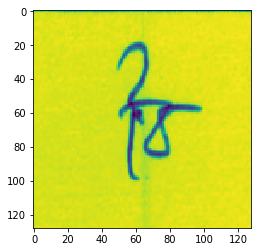

In [6]:
plt.imshow(xTrainData2[100])
plt.show

gc.collect()

In [7]:
def image_resized(dataframe, image_id, size):
    HEIGHT = 137
    WIDTH = 236
    img = dataframe[image_id]
    pad = int(100)
    border = int(pad/10)
    first_size = int(pad*0.8)
    #img = np.float32(img)
    img = np.uint8(np.abs(img))
    img2 = np.uint8(np.abs(np.full((pad,pad), 254)))
    image = cv2.GaussianBlur(img, (3,3), 10.0)
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0, image)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) 
    image = cv2.filter2D(image, -1, kernel)
    _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV +  cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(image,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0 
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)
    
    img = img[ymin:ymax,xmin:xmax]
    img = cv2.resize(img, (first_size,first_size),interpolation=cv2.INTER_AREA)
    
    
    img2[border:first_size+border,border:first_size+border]=img
    img = cv2.resize(img2, (size,size),interpolation=cv2.INTER_AREA)

    return img


In [8]:
xTrainData = []
xTestData = []

for z in tqdm(range(xTrainData2.shape[0])):
    xTrainData.append(image_resized(xTrainData2, z, 75))

for z in tqdm(range(xTestData2.shape[0])):
    xTestData.append(image_resized(xTestData2, z, 75))
    

100%|██████████| 10042/10042 [00:04<00:00, 2454.18it/s]


In [9]:
del xTrainData2
del xTestData2

In [10]:
gc.collect()

2283

168
13


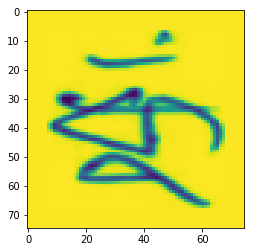

In [11]:
plt.imshow(xTrainData[1000])
plt.show
num_classes = (yTrainData.shape[1])
print(num_classes)
gc.collect()
print(np.argmax(yTrainData[1000]))

In [12]:
IMG_SIZE = len(xTrainData[1][0])
xTrainData = np.array(xTrainData).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
xTestData = np.array(xTestData).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(xTrainData.shape)
print(xTestData.shape)

(190798, 75, 75, 1)
(10042, 75, 75, 1)


In [13]:
IMG_SIZE = xTrainData.shape[1]
input_shape = xTrainData.shape[1:]
print(xTrainData.shape)
print(xTestData.shape)
print(input_shape)

(190798, 75, 75, 1)
(10042, 75, 75, 1)
(75, 75, 1)


In [14]:
xTrainData = xTrainData/np.float32(255.0)
xTestData = xTestData/np.float32(255.0)

In [15]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(xTrainData, axis=0)
    xTrainData -= x_train_mean
    xTestData -= x_train_mean

print('xTrainData shape:', xTrainData.shape)
print(xTrainData.shape[0], 'train samples')
print(xTestData.shape[0], 'test samples')
print('y_train shape:', yTrainData.shape)
print('y_test shape:', yTestData.shape)

# Convert class vectors to binary class matrices.


xTrainData shape: (190798, 75, 75, 1)
190798 train samples
10042 test samples
y_train shape: (190798, 168)
y_test shape: (10042, 168)


In [16]:
print('y_train shape:', yTrainData.shape)
print('y_test shape:', yTestData.shape)


y_train shape: (190798, 168)
y_test shape: (10042, 168)


In [17]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-1
    if epoch > 40:
        lr *= 0.5e-4
    elif epoch > 30:
        lr *= 1e-4
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr


In [18]:
# Prepare model model saving directory.
'''save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)'''

# Prepare callbacks for model saving and for learning rate adjustment.
'''checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)'''

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

'''lr_reducer = ReduceLROnPlateau(monitor='dense_2_accuracy', 
                                            patience=2, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)'''

#callbacks = ['''checkpoint,''' lr_reducer, lr_scheduler]
callbacks = [lr_reducer]

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [20]:
#base_model = InceptionV3(input_shape = input_shape, weights=None, include_top=False)
base_model = keras.applications.resnet_v2.ResNet152V2(input_shape = input_shape, weights=None, include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers


In [21]:
model.load_weights('/kaggle/input/model-root-resnet/resnet152v2_root.hdf5', by_name=True)
print(len(model.get_weights()))


818


In [22]:
print(model.get_weights())

[array([[[[ 0.04420074, -0.06502223, -0.15928411, ...,  0.07267349,
          -0.16582593, -0.06029259]],

        [[ 0.04028144, -0.0287465 , -0.13565832, ...,  0.07361981,
          -0.17686893, -0.03018997]],

        [[-0.05832126,  0.00239237,  0.0759337 , ...,  0.0193122 ,
          -0.01549284, -0.23486418]],

        ...,

        [[ 0.23498373, -0.07622894,  0.02037938, ..., -0.04675467,
           0.16767092, -0.16437337]],

        [[-0.03304832, -0.15418124, -0.11596722, ..., -0.07236719,
           0.14612986, -0.02479533]],

        [[-0.3298391 , -0.08261026, -0.03064955, ..., -0.1622496 ,
           0.11560197,  0.20596264]]],


       [[[-0.07965259, -0.11215204, -0.09962227, ..., -0.07545336,
          -0.1007148 ,  0.09354737]],

        [[-0.11112352, -0.03235653, -0.20857601, ..., -0.11141159,
          -0.1984225 ,  0.03244677]],

        [[-0.1578922 ,  0.0997778 , -0.20227145, ..., -0.10390047,
          -0.06517857, -0.30628806]],

        ...,

        [[ 0.45

In [23]:
def train1(epochs):
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])

    # train the model on the new data for a few epochs
    #model.fit_generator(...)
    model.fit_generator(datagen.flow(xTrainData, yTrainData, batch_size=batch_size),
                            validation_data=(xTestData, yTestData),
                            epochs=epochs, verbose=1, workers=4)



In [24]:
def train2(epochs):
    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate

    model.compile(optimizer=SGD(momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    model.fit_generator(datagen.flow(xTrainData, yTrainData, batch_size=batch_size),
                            validation_data=(xTestData, yTestData),
                            epochs=epochs, verbose=1, workers=4,
                            callbacks=callbacks)

In [25]:
for layer in model.layers[:563]:
       layer.trainable = True
for layer in model.layers[563:]:
   layer.trainable = False
train2(epochs+10)

Epoch 1/20
1491/1491 [==============================] - 810s 543ms/step - loss: 0.2378 - accuracy: 0.9300 - val_loss: 0.1704 - val_accuracy: 0.9476
Epoch 2/20
1491/1491 [==============================] - 747s 501ms/step - loss: 0.2247 - accuracy: 0.9335 - val_loss: 0.1853 - val_accuracy: 0.9418
Epoch 3/20
1491/1491 [==============================] - 737s 494ms/step - loss: 0.2115 - accuracy: 0.9372 - val_loss: 0.2102 - val_accuracy: 0.9398
Epoch 4/20
1491/1491 [==============================] - 731s 490ms/step - loss: 0.2112 - accuracy: 0.9376 - val_loss: 0.1988 - val_accuracy: 0.9430
Epoch 5/20
1491/1491 [==============================] - 728s 488ms/step - loss: 0.1978 - accuracy: 0.9408 - val_loss: 0.2492 - val_accuracy: 0.9348
Epoch 6/20
1491/1491 [==============================] - 732s 491ms/step - loss: 0.1907 - accuracy: 0.9422 - val_loss: 0.1900 - val_accuracy: 0.9470

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0031622775894859655.
Epoch 7/20
1491/1491 [=========

In [26]:
'''for layer in model.layers[:563]:
       layer.trainable = False
for layer in model.layers[563:]:
   layer.trainable = True
train1(epochs-6)'''

'for layer in model.layers[:563]:\n       layer.trainable = False\nfor layer in model.layers[563:]:\n   layer.trainable = True\ntrain1(epochs-6)'

In [27]:
'''for epoch in range(epochs-8):
    for layer in model.layers[:563]:
       layer.trainable = False
    for layer in model.layers[563:]:
       layer.trainable = True
    
    train1(1)
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:563]:
       layer.trainable = True
    for layer in model.layers[563:]:
       layer.trainable = False
    
    train2(1)'''

'for epoch in range(epochs-8):\n    for layer in model.layers[:563]:\n       layer.trainable = False\n    for layer in model.layers[563:]:\n       layer.trainable = True\n    \n    train1(1)\n    # we chose to train the top 2 inception blocks, i.e. we will freeze\n    # the first 249 layers and unfreeze the rest:\n    for layer in model.layers[:563]:\n       layer.trainable = True\n    for layer in model.layers[563:]:\n       layer.trainable = False\n    \n    train2(1)'

In [28]:
model.save('resnet152v2_root_model_2.hdf5')